# Preprocessing

[Wiese et al., Quant GANs: Deep Generation of Financial Time Series, 2019](https://arxiv.org/abs/1907.06673)

Prior to passing a realization of a financial time series $s_{0:T} ∈ \mathbb{R}^{N_X×(T+1)}$ to the discriminator, the time series has to be preprocessed. The applied pipeline is displayed in Figure 9. We briefly explain each of the steps taken. Note that all of the used transformations, excluding the rolling window, are invertible and thus, allow a series sampled from a log return NP to be post-processed by inverting the steps 1-4 to obtain the desired form. Also, observe that the pipeline includes the inverse Lambert W
transformation as earlier discussed in subsection 5.3.

![Preprocessing Pipeline](preprocess/ScreenshotWiese_et_al.png)

In [1]:
#%%capture
import os, sys
file_name = 'ShanghaiSE_daily'  # 'ShanghaiSE_daily' or 'SP500_daily'
colab = 'COLAB_GPU' in os.environ
file_path = f'./data/{file_name}.csv'  
if colab:
	file_path = f'/content/temporalCN/data/{file_name}.csv'
	username = "JamesSullivan"
	repository = "temporalCN"
	!git clone https://github.com/{username}/{repository}.git
	sys.path.append('/content/temporalCN/')

## Load and Examine Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

from preprocess.acf import *
from preprocess.gaussianize import *

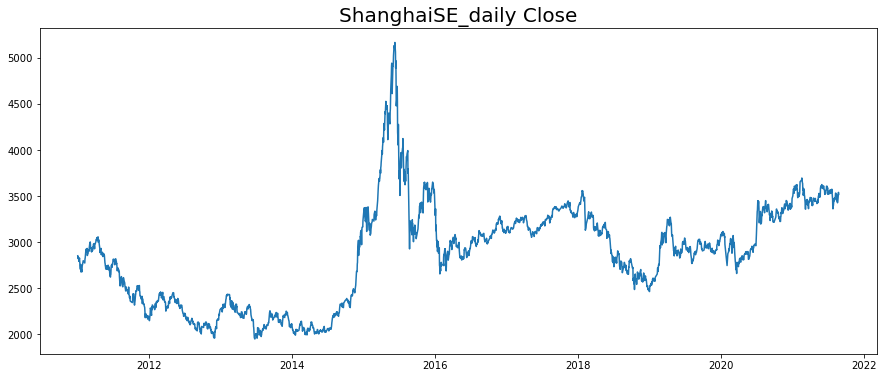

In [3]:
def dateparse(d):
    return pd.Timestamp(d)

data = pd.read_csv(file_path, parse_dates={'datetime': ['Date']}, date_parser=dateparse)
df = data['CLOSE']
fig = plt.figure(figsize=(15,6))
plt.title(f'{file_name} Close', fontsize=20)
plt.plot(data['datetime'], data['CLOSE'] )
plt.show()

First, note that the performance of a stock over a certain period (as e.g. a day, a month or a year) is
given by its relative return, either $ R_t = (S_t - S_{t−1})/S_{t−1} $ or its log return $ R_t = log(S_t) - log(S_{t−1}) $.

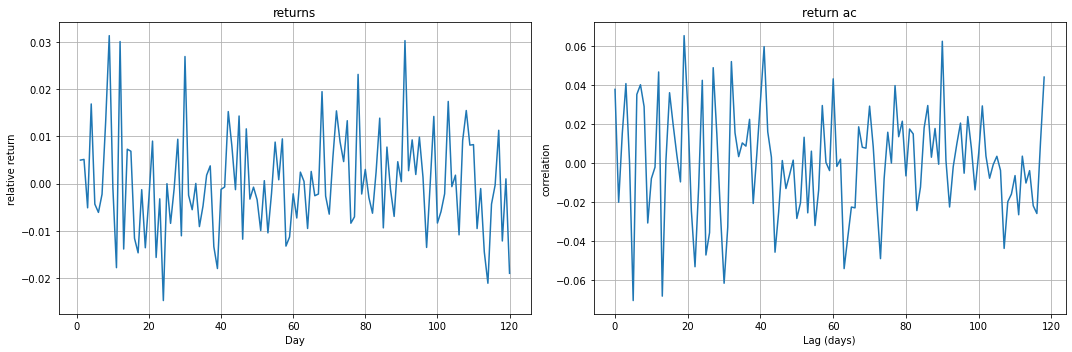

In [4]:
returns = df.shift(1)/df - 1
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

#axs[0].plot(returns[:50])
axs[0].plot(returns[1:121])
axs[0].set_title('returns')
axs[1].plot(acf(returns, 120)[1:])
axs[1].set_title('return ac')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()

## Step 1: Log returns $r_{1:T}$

Calculate the log return series
$$r_t = \log\biggl(\frac{s_t}{s_{t-1}}\biggr) \text { for all } t \in \{1, ..., T\}.$$

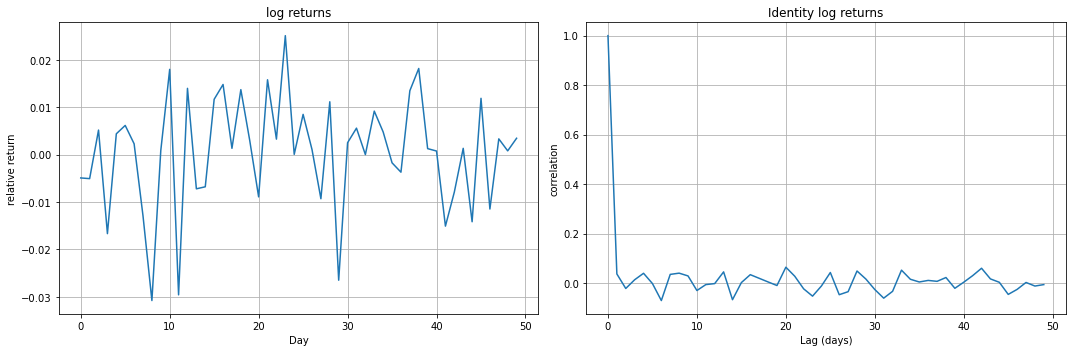

In [5]:
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

#axs[0].plot(returns[:50])
axs[0].plot(log_returns[0:50])
axs[0].set_title('log returns')
axs[1].plot(acf(log_returns, 50))
axs[1].set_title('Identity log returns')

for ax in axs: ax.grid(True)
plt.setp(axs[0], xlabel='Day')
plt.setp(axs[1], xlabel='Lag (days)')
plt.setp(axs[0], ylabel='relative return')
plt.setp(axs[1], ylabel='autocorrelation')
axs[1].set_ylabel('correlation')
plt.tight_layout()

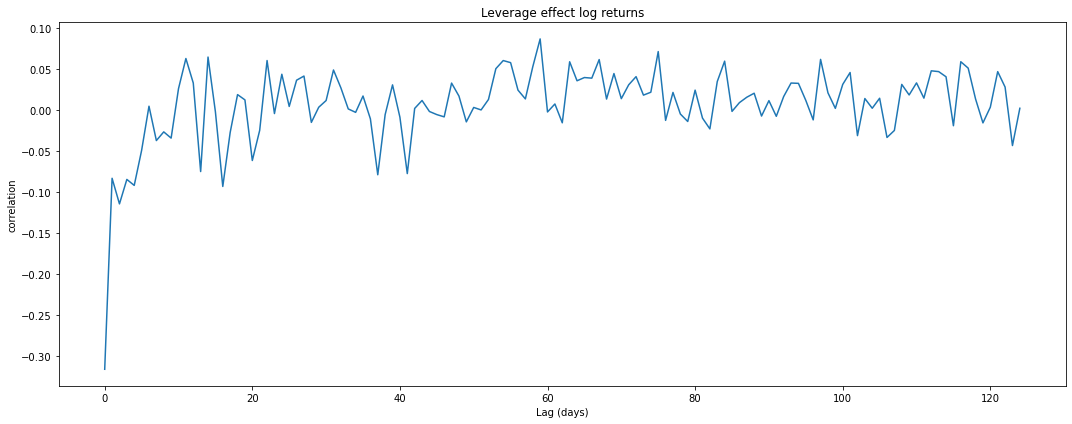

In [6]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(acf(log_returns, 125, le=True))
ax.set_title('Leverage effect log returns')
plt.setp(ax, xlabel='Lag (days)')
plt.setp(ax, ylabel='autocorrelation')
ax.set_ylabel('correlation')
plt.tight_layout()

## Step 2 & 4: Normalize
For numerical reasons, we normalize the data in order to obtain a series with zero mean and unit
variance, which is thoroughly derived in LeCun et al. (1998).

In [7]:
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

## Step 3: Inverse Lambert W transform
The suggested transformation applied to the log returns of the S&P 500 is displayed in Figure 10. It shows the standardized original distribution of the S&P 500 log returns and the inverse Lambert W transformed log return distribution. Observe that the transformed standardized log return distribution in Figure 10b approximately follows the standard normal distribution and thereby circumvents the issue of not being able to generate the heavy-tail of the original distribution.

## Step 5: Rolling window
When considering a discriminator with receptive field size $T^{(d)}$, we apply a rolling window of Corresponding length and stride one to the preprocessed log return sequence $r^{(ρ)}_t $. Hence, for $t∈\{1,...,T −T^{(d)}\}$ we define the sub-sequences
$$r^{(t)}_{1:T^{(d)}} := r^{(ρ)}_{t:(T^{(d)}+t−1)} ∈  \mathbb{R}^{N_Z×T^{(d)}}.$$

Remark 6.1. Note that sliding a rolling window introduces a bias, since log returns at the beginning
and end of the time series are under-sampled when training the Quant GAN. This bias can be corrected
by using a (non-uniform) weighted sampling scheme when sampling batches from the training set.

In [8]:
# Receptive Field Size 127 from paper
log_returns_rolled = rolling_window(log_returns_preprocessed, 127)

(-4.0, 4.0)

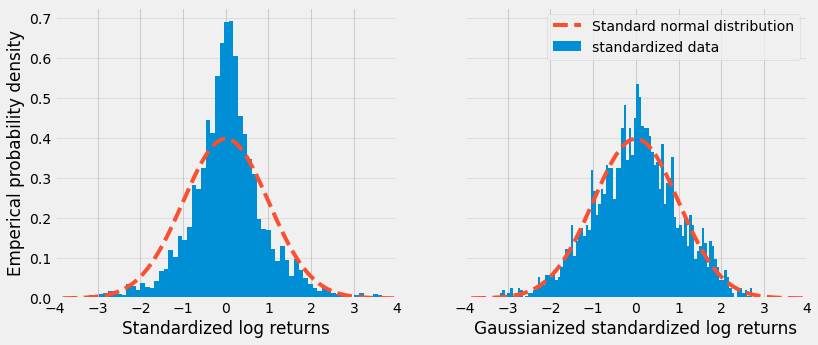

In [18]:
fig, ax = plt.subplots(ncols=2, figsize=(12, 5), sharey=True, sharex=True)
# Log returns before and after the lambert W inverse transform respectively (both standardized). 
plt.style.use('fivethirtyeight')

ax[0].hist(standardScaler1.transform(log_returns), bins=100, density=True)
x_range = np.linspace(*ax[0].get_xlim(), num=1000)
ax[0].plot(x_range, norm.pdf(x_range), linestyle='dashed')

ax[1].hist(log_returns_preprocessed, bins=100, density=True)
x_range = np.linspace(*ax[1].get_xlim(), num=1000)
ax[1].plot(x_range, norm.pdf(x_range), linestyle='dashed')

# add a grid to compare easily
ax[0].yaxis.grid(True, alpha=0.5)
ax[1].yaxis.grid(True, alpha=0.5);

ax[1].legend(['Standard normal distribution', 'Standardized data'])
ax[0].set_ylabel('Emperical probability density')
ax[0].set_xlabel('Standardized log returns')
ax[1].set_xlabel('Gaussianized standardized log returns')

ax[0].set_xlim(-4, 4)